<div style="background-color:#783465 ; text-align:center; vertical-align: middle; padding:40px 0; margin-top:30px">
<h1 style="color:white"> OpenAI API</h1>
    
<h4 style="color:black"> Datalab V: Julia Boschman, Isa Dijkstra, Daan Eising, Rogier Gernaat </h4>

<a name='start'></a>


Dit notebook is onderdeel van een verkennend onderzoek voor Kennisnet, waarin we verschillende manieren testen om een AI-ondersteunde chatbot te bouwen die scholen helpt bij het opstellen van een leermiddelenbeleid.

Het doel van dit notebook is om een **alternatieve implementatie van onze Custom-GPT** te maken – niet via het GPT-platform van OpenAI, maar direct via de API. Zo kunnen we:
- Meer controle krijgen over **prompts, system-instructies en geheugenbeheer**.
- Zelf **hyperparameter tuning** uitvoeren en effecten vergelijken.
- Mogelijkheid aanraden voor uitbreiding zoals API implementaties voor bestanden downloaden of meer gespecialiseerd zoeken uit een kennisbank met bijvoorbeeld (RAG)
- Outputs systematisch verzamelen en beoordelen.

Deze aanpak maakt het mogelijk om de prestaties, consistentie en creativiteit van verschillende instellingen en varianten uitgebreid te testen. We voeren bijvoorbeeld een gridsearch uit op belangrijke generatieve hyperparameters en vergelijken de resultaten inhoudelijk.

Door deze twee proof of concepts (de no-code Custom-GPT en deze notebookversie) naast elkaar te zetten, kunnen we Kennisnet onderbouwd adviseren welke route het beste past bij hun wensen en praktijk.

In [1]:
# pip install openai
!pip install --upgrade openai



     -------------------------------------- 725.5/725.5 kB 6.6 MB/s eta 0:00:00
     ---------------------------------------- 73.5/73.5 kB 4.2 MB/s eta 0:00:00
  Using cached distro-1.9.0-py3-none-any.whl (20 kB)
     ------------------------------------- 444.2/444.2 kB 14.0 MB/s eta 0:00:00
     ------------------------------------- 207.5/207.5 kB 12.3 MB/s eta 0:00:00
     ---------------------------------------- 78.8/78.8 kB 4.3 MB/s eta 0:00:00
     ---------------------------------------- 2.0/2.0 MB 11.3 MB/s eta 0:00:00
  Using cached annotated_types-0.7.0-py3-none-any.whl (13 kB)


[Back to the top](#start)
<a name='5.0'></a>

<div style="background-color:#783465; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H1: Opzetten van de omgeving</strong></h2>
</div>

## Introductie

In dit project bouwen we een eigen AI-chatbot die via de OpenAI API werkt. Deze aanpak verschilt van het gebruik van een Custom GPT binnen ChatGPT: er zijn meer technische stappen, maar ook veel meer controle over de werking, prompts, context, kosten en integratiemogelijkheden.

## Uitleg van de class `OpenAIChatbot`

- **API-key beveiliging:**  
  De API-key wordt niet hardcoded, maar moet door de gebruiker via de terminal (`input()`) worden ingevoerd. Dit is veilig, zodat er geen sleutels op GitHub of elders kunnen lekken.

- **Extern system prompt-bestand:**  
  In plaats van een prompt in de code, staat de volledige system prompt in een apart tekstbestand (`system-prompts.txt`). Hierdoor is de instructie makkelijk aan te passen en kan dezelfde set regels gebruikt worden als in een Custom GPT. Zo waarborg je consistent gedrag van je chatbot.

- **Modelinstelling:**  
  De chatbot maakt gebruik van het `"gpt-4o"` model, maar dit is eenvoudig aanpasbaar naar andere modellen als we dat willen testen.

- **Chatgeschiedenis:**  
  Alle berichten (zowel van de gebruiker als de AI) worden opgeslagen in de variabele `history`, zodat de context in stand blijft. Dit is belangrijk voor coherente, contextgevoelige antwoorden.

- **Kostenberekening:**  
  Na elke beurt worden de kosten berekend op basis van het aantal input- en outputtokens, volgens de actuele OpenAI-prijzen. Zo krijg je inzicht in het verbruik en de kosten van je sessie. Aan het eind van het gesprek wordt het totaal getoond.

## Belangrijke aandachtspunten

- **Kennisbestanden toevoegen:**  
  In tegenstelling tot Custom GPT kun je in deze basisopzet niet direct kennisbestanden 'uploaden' waar het model uit zichzelf toegang toe heeft. Later in het project kun je document parsing en retrieval-functionaliteit toevoegen, waarbij je relevante passages uit je kennisbank als context meegeeft in je prompt.

- **Verbeterpunten en uitbreidingen:**  
  Mogelijke verbeteringen zijn onder andere het toevoegen van kennis via retrieval (RAG) of andere techniek, het uitbreiden met een webinterface, het automatisch opslaan van gesprekken, en het verbeteren van kostenmanagement. Deze uitbreidingen kunnen stap voor stap in het notebook worden verwerkt.

- **Bewustwording van kosten:**  
  Door de kostenberekening direct inzichtelijk te maken, zijn wij als gebruiker bewust van het daadwerkelijke verbruik en de kosten die horen bij een voorbeeldsessie of test. Dit is ook belangrijk en uiteraard respectvol naar kennisnet dat we bewust testen




In [2]:
import os

class OpenAIChatbot:
    def __init__(self):
        import openai
        self.api_key = input("Voer je OpenAI API key in: ").strip()
        self.client = openai.OpenAI(api_key=self.api_key)
        self.model = "gpt-4o"
        self.history = [self._get_system_prompt()]
        self.total_cost = 0.0  # In USD

        # Laad beleidsvoorbeelden
        self.kennisbank = self._load_beleidsvoorbeelden("Beleidsvoorbeelden")

    def _get_system_prompt(self):
        with open("system-prompts.txt", encoding="utf-8") as f:
            system_prompt = f.read()
        return {"role": "system", "content": system_prompt}

    def _load_beleidsvoorbeelden(self, folder_path):
        kennisbank = {}
        if not os.path.isdir(folder_path):
            print(f"Let op: map '{folder_path}' bestaat niet!")
            return kennisbank
        for fname in os.listdir(folder_path):
            if fname.endswith(".txt"):
                with open(os.path.join(folder_path, fname), encoding="utf-8") as f:
                    kennisbank[fname] = f.read()
        print(f"{len(kennisbank)} beleidsvoorbeelden geladen!")
        return kennisbank

    def _zoek_inspiratie(self, vraag):
        resultaten = []
        # Zoek op kernwoorden uit de vraag in alle beleidsvoorbeelden
        for doc in self.kennisbank.values():
            for para in doc.split('\n\n'):
                if any(kw.lower() in para.lower() for kw in vraag.split()):
                    resultaten.append(para.strip())
        return resultaten[:3]  # Maximaal 3 korte fragmenten meesturen

    def _calculate_cost(self, response):
        usage = response.usage
        input_tokens = usage.prompt_tokens
        output_tokens = usage.completion_tokens
        input_cost = (input_tokens / 1_000_000) * 5
        output_cost = (output_tokens / 1_000_000) * 15
        total = input_cost + output_cost
        return total, input_tokens, output_tokens

    def chat(self):
        print("Typ 'stop' om te stoppen.\n")
        while True:
            user_input = input("\nJij: ")
            if user_input.lower() == 'stop':
                print("\nGesprek beëindigd.")
                break

            self.history.append({"role": "user", "content": user_input})

            response = self.client.chat.completions.create(
                model=self.model,
                messages=self.history,
                max_tokens=500
            )
            answer = response.choices[0].message.content
            print(f"\nKennisnet AI: {answer}\n")
            self.history.append({"role": "assistant", "content": answer})

            # Kosten optellen en tonen
            cost, input_tokens, output_tokens = self._calculate_cost(response)
            self.total_cost += cost
            print(f"-- Kosten deze chat: ${cost:.6f} USD ({input_tokens} input tokens, {output_tokens} output tokens) --")
            print(f"   Totale kosten tot nu toe: ${self.total_cost:.6f} USD\n")

        print(f"\nTotale kosten van deze sessie: ${self.total_cost:.6f} USD")

if __name__ == "__main__":
    bot = OpenAIChatbot()
    bot.chat()

11 beleidsvoorbeelden geladen!
Typ 'stop' om te stoppen.


Kennisnet AI: Hallo! Welkom bij het proces voor het opstellen van een concept-leermiddelenbeleid. Samen gaan we door verschillende hoofdstukken en paragrafen om een gedetailleerd en persoonlijk beleidsdocument te creëren voor jouw school. Dit proces bestaat uit meerdere stappen waarbij ik je vragen stel die je beantwoordt in bullets. Na elk hoofdstuk gaan we samen de antwoorden controleren voordat we verdergaan.

Het is aan te raden om dit samen te doen met een werkgroep, zoals een schoolleider, ICT-coördinator, vakgroep leider of leermiddelencoördinator.

Voordat we beginnen, zullen we enkele basisgegevens vastleggen:

1. **De naam van de school:**
2. **De locatie van de school:**
3. **Het type onderwijs (bijv. basisonderwijs, voortgezet onderwijs, mbo, etc.):**

Als je documenten bij de hand hebt zoals het koersplan, ICT-beleid of andere relevante stukken, laat het me weten. Die kunnen namelijk helpen om het beleid persoonlij

[Back to the top](#start)
<a name='5.0'></a>

<div style="background-color:#783465; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H2: Testen van de omgeving</strong></h2>
</div>

### **Eerste prototype**

In deze eerste testronde is de chatbot getest met de standaard system prompts van onze ```custom GPT```, in een eenvoudige Streamlit-omgeving. We hebben geen aanpassingen gedaan aan de prompts of hyperparameters, zodat we goed konden beoordelen of de basisstructuur, gespreksopbouw en bevestigingsrondes werkten zoals bedoeld. Deze nulmeting dient als een uitgangspunt voor verdere optimalisatie en vergelijking met geavanceerdere versies en uiteraard ook gewoon als testronde of het allemaal correct zou werken.

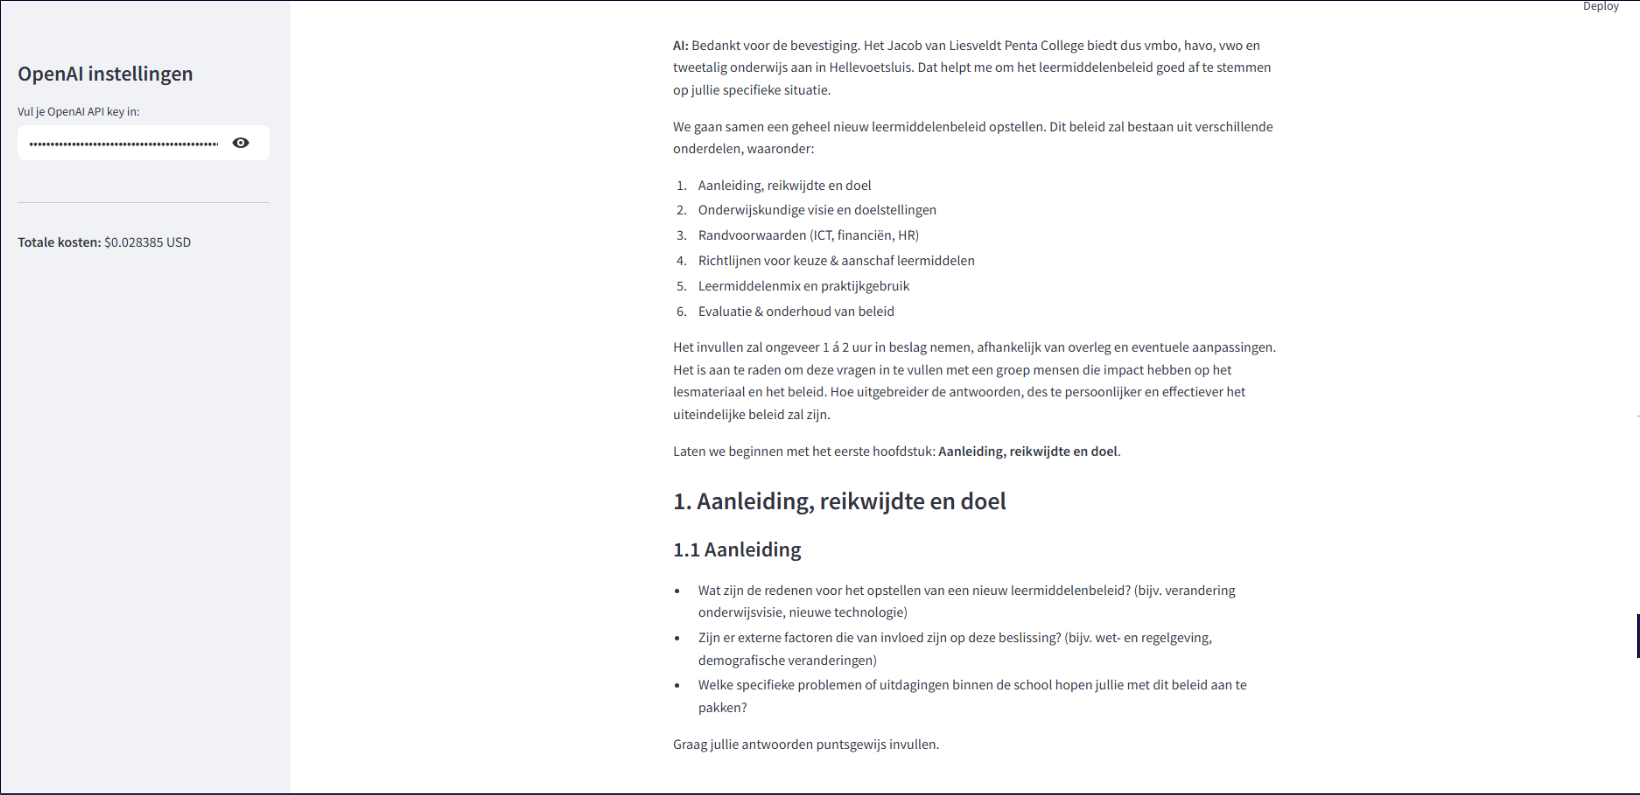

### **Opmerkingen eerste ronde**
We hebben een aantal basis testjes gedaan en kwamen op een hele hoop goede punten, zoals dat de chatbot de structuur van de system prompts mooi overneemt. Hij begrijpt het stappenplan en volgt deze ook al redelijk goed. Ook herkent hij de blokkades die we hadden ingesteld, bijvoorbeeld bij het stellen van vragen over onderwerpen die niet van toepassing zijn op de implementatie. Denk aan algemene vragen zoals: “Wat is er lekker op de barbecue?” of “Kan je me helpen met mijn huiswerk?”

Waar nog verbeterpunten liggen, is vooral in de structuur van de antwoorden die hij terugstuurt. Alles, behalve de hoofdstukken met vragen zoals 1.1 Aanleiding, geeft hij terug in een lopende tekst. Dit maakt het lastiger om de output van de chatbot snel en goed te begrijpen, en het ontbreekt aan een nette structuur met bijvoorbeeld dikgedrukte kopjes, een duidelijke splitsing tussen onderwerpen en bulletpoints. Het zou er daardoor een stuk netter en professioneler uitzien. We hadden hier wel system prompts voor opgenomen, maar dit gaf ons direct het signaal dat het niet zo simpel is als het klakkeloos overnemen van de system prompts en verwachten dat de implementatie hetzelfde werkt als bij de custom GPT. We zullen de regels veel moeten testen en de system prompts opnieuw optimaliseren voor de OpenAI API. Gelukkig hebben we al een goede basis qua structuur en antwoorden, dus het zal minder tijd kosten dan het hele testproces bij de custom GPT.

En ook al is dit een proof of concept en eigenlijk alleen bedoeld voor testing en vergelijking, wilden we wel een mooie UI die ook echt bij Kennisnet past. Daarom hebben we gekozen voor een nettere UI met duidelijke tekstvakken.

Zoals je in deze test kunt zien, houdt de chatbot zich goed aan de volgorde en weet hij wat hij moet doen. De system prompts worden tot nu toe goed meegenomen en zijn ook gemakkelijk aan te passen.

Een nadeel is nu vooral dat je meteen ziet dat de chatbot bepaalde informatie niet tot zijn beschikking heeft. De aanleiding in de “Format vragen” bestaat bijvoorbeeld uit:

### **Aanleiding, reikwijdte en doel** 

**1.1 Aanleiding**  

- Wat is de directe aanleiding voor het opstellen van een (nieuw) leermiddelenbeleid? Bijvoorbeeld strategische doelen, evaluatie huidige middelen, opbrengsten (interne factoren). 

- Zijn er wettelijke of aanbestedingseisen die om een (vernieuwd) leermiddelenbeleid vragen? Bijvoorbeeld aanbestedingsplicht, nieuwe onderwijstrends of veranderd curriculum (externe factoren). 

Wat nu natuurlijk niet overeenkomt met wat de chatbot terug stuurt omdat hij nog geen kennisbank/knowledge heeft waar hij informatie uit kan halen

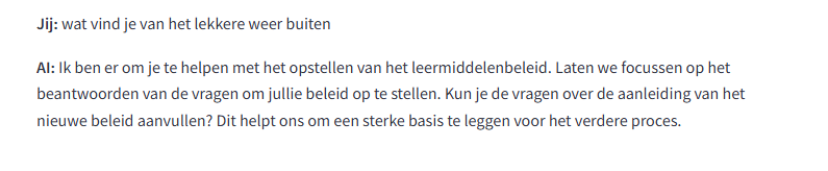

### **Verbeterpunten die we op basis van de test ronde gaan toepassen**

**1. Structurering van de output verbeteren**

- Antwoorden moeten niet alleen als lopende tekst verschijnen, maar voorzien zijn van duidelijke kopjes, bulletpoints en vetgedrukte titels waar nodig.

- De chatbot moet de exacte nummering, hoofdstukindeling en opmaak zoals gespecificeerd in de system prompts aanhouden.

**2. Format strikter afdwingen**

- System prompts en het stappenplan moeten verder worden aangescherpt zodat de chatbot consequent de gewenste structuur volgt.
    - Dit zullen we proberen als informatie mee tegeven de zelfde manier als we de system prompts (regels) geven aan de chatbot
- Herformuleren van prompts waar nodig om ambiguïteit te voorkomen.

**3. Professionelere UI**

- Het chatvenster en de tekstvakken moeten overzichtelijker en duidelijker vormgegeven worden zodat de gebruiker direct ziet waar welk antwoord hoort.

**4. Antwoord op niet-relevante vragen beter blokkeren**

- Nog strikter voorkomen dat de chatbot antwoord geeft op onderwerpen buiten het leermiddelenbeleid (zoals algemene of irrelevante vragen).

**5. Prompt tuning en optimalisatie**

- Testen en optimaliseren van de system prompts specifiek voor de OpenAI API, zodat deze dezelfde werking en structuur garanderen als bij de custom GPT.

**6. Gebruikerservaring**

- Het proces van starten, doorgaan naar volgende hoofdstukken en het verzamelen van antwoorden duidelijker en gebruiksvriendelijker maken.

**7. Transparantie over ontbrekende informatie**

- De chatbot moet explicieter aangeven wanneer informatie ontbreekt (zoals de aanleiding of context uit documenten) en daar gerichte vervolgvragen over stellen.

[Back to the top](#start)
<a name='5.0'></a>

<div style="background-color:#783465; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H3: Hyperparameter tuning</strong></h2>
</div>

### Hyperparameter tuning & prompt engineering bij generatieve AI

Bij het optimaliseren van de output van grote taalmodellen zoals GPT-3.5/4 kun je een aantal **hyperparameters** instellen. Deze instellingen bepalen hoe het model reageert en hoeveel variatie, creativiteit en consistentie er in de gegenereerde tekst zit. De belangrijkste parameters zijn:

- **`temperature`**:  
  Stuurt de **creativiteit en variatie** van het model aan.  
  - *Lage waardes* (rond 0.0–0.4): maken de output voorspelbaar, feitelijk en minder verrassend (vaak telkens hetzelfde antwoord).  
  - *Hoge waardes* (0.7–1.5): zorgen voor meer creativiteit en diversiteit, maar kunnen soms minder consistente output geven.  
  - In ons experiment hebben we gezien dat hogere temperatures leiden tot originelere beleidsvoorbeelden, maar soms ook iets minder consistent qua structuur.

- **`top_p` (nucleus sampling):**  
  Bepaalt hoeveel **diversiteit** het model toelaat bij het kiezen van de volgende woorden.  
  - Een lage waarde (zoals 0.7) zorgt dat alleen de meest waarschijnlijke woorden gekozen worden (minder variatie).  
  - Een waarde van 1.0 laat het model uit alle mogelijke woorden kiezen (meer variatie).

- **`frequency_penalty`**:  
  Straft het herhalen van woorden binnen de output.  
  - Een hogere waarde ontmoedigt het model om bepaalde woorden vaak te herhalen.  
  - Dit helpt om meer gevarieerde en leesbare teksten te genereren.

- **`presence_penalty`**:  
  Moedigt het model juist aan om **nieuwe woorden en onderwerpen** toe te voegen die nog niet in de context zaten.  
  - Een hogere waarde zorgt dat het model vaker nieuwe concepten introduceert in plaats van te blijven hangen in herhaling of dezelfde termen.

- **`max_tokens`**:  
  Bepaalt de **maximale lengte** van de output, oftewel het maximaal aantal gegenereerde tokens/woorden.  
  - In deze test hebben we de lengte bewust beperkt gehouden om compacte, goed vergelijkbare antwoorden te krijgen.

#### Zelfde vraag testen met verschillende instellingen

Door genoeg te varieren met de parameters kunnen we kijken welke parameters zorgen voor voorspelbaarheid en consistentie of creativiteit en originaliteit. Sinds we zo uniek mogelijke leermiddelenbeleidsstukken willen genereren gaan we kijken welke parameters het beste passen bij deze waardes



#### We testen het script met 1 voorbeeld om te kijken of de output werkt

In [9]:
import openai

openai.api_key = input("Voer je OpenAI API key in: ").strip()

# Laad system prompt uit bestand
with open("system-prompts.txt", encoding="utf-8") as f:
    system_prompt = f.read()

user_prompt = (
    "Perfect, dan kunnen we beginnen met het opstellen van het leermiddelenbeleid. "
    "Laten we starten met **Hoofdstuk 1: Aanleiding, reikwijdte en doel**.\n"
    "1.1 Aanleiding\n"
    "- Wat is de directe aanleiding voor het opstellen van een (nieuw) leermiddelenbeleid? Bijvoorbeeld strategische doelen, evaluatie huidige middelen, opbrengsten (interne factoren).\n"
    "- Zijn er wettelijke of aanbestedingseisen die om een (vernieuwd) leermiddelenbeleid vragen? Bijvoorbeeld aanbestedingsplicht, nieuwe onderwijstrends of veranderd curriculum (externe factoren).\n"
    "Geef je antwoorden puntsgewijs alsjeblieft."
)
user_answer = (
    "Directe aanleiding: We willen ons leermiddelenbeleid vernieuwen vanwege de evaluatie van het huidige beleid, met name de balans tussen digitaal en papier. "
    "Externe factoren: Nieuwe landelijke richtlijnen en aanbestedingsplicht. "
    "Interne doelen: Meer regie op keuze en digitalisering, kosten, gebruiksvriendelijkheid."
)

# Kies hyperparameters
temperature = 0.6
top_p = 0.85
frequency_penalty = 0.0
presence_penalty = 0.0

print(f"Test met: temperature={temperature}, top_p={top_p}, frequency_penalty={frequency_penalty}, presence_penalty={presence_penalty}\n")

try:
    # Eerste AI-call: AI stelt de vragen (1.1)
    history = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt},
    ]
    ai_response = openai.chat.completions.create(
        model="gpt-4o",
        messages=history,
        temperature=temperature,
        top_p=top_p,
        frequency_penalty=frequency_penalty,
        presence_penalty=presence_penalty,
        max_tokens=250
    )
    vraag_antwoord = ai_response.choices[0].message.content.strip()
    print("AI (vraagstelling 1.1):\n", vraag_antwoord)
    # Tweede AI-call: AI schrijft het beleidsstuk op basis van het antwoord van de gebruiker
    history.append({"role": "assistant", "content": vraag_antwoord})
    history.append({"role": "user", "content": user_answer})
    policy_response = openai.chat.completions.create(
        model="gpt-4o",
        messages=history,
        temperature=temperature,
        top_p=top_p,
        frequency_penalty=frequency_penalty,
        presence_penalty=presence_penalty,
        max_tokens=250
    )
    beleidstekst = policy_response.choices[0].message.content.strip()
    print("\nAI (beleidstekst op basis van antwoord):\n", beleidstekst)
except Exception as e:
    print("Error tijdens test:", e)


Test met: temperature=0.6, top_p=0.85, frequency_penalty=0.0, presence_penalty=0.0

AI (vraagstelling 1.1):
 Voordat we beginnen met het invullen van de vragen, wil ik graag enkele belangrijke gegevens van de school verzamelen. Dit helpt bij het personaliseren van het leermiddelenbeleid. Kunt u alstublieft de volgende informatie bevestigen:

- **Naam van de school:**
- **Locatie van de school:**
- **Type onderwijs (bijv. basisonderwijs, voortgezet onderwijs):**

Is deze informatie correct? Ja/Nee. Zodra dit is bevestigd, gaan we verder met de inhoudelijke vragen van Hoofdstuk 1.

AI (beleidstekst op basis van antwoord):
 Dank voor uw input. Laten we deze informatie verwerken in een samenhangend beleidsstuk voor paragraaf 1.1 Aanleiding.

---

**1.1 Aanleiding**

De directe aanleiding voor het opstellen van een vernieuwd leermiddelenbeleid is de evaluatie van het huidige beleid, waarbij specifiek is gekeken naar de balans tussen digitale en papieren leermiddelen. Deze evaluatie heeft aa

### **De Gridsearch met combinaties van hyperparameters**

In [13]:
import os
import openai
import pandas as pd
import itertools
import time

class OpenAIChatbot:
    def __init__(self):
        self.api_key = input("Voer je OpenAI API key in: ").strip()
        openai.api_key = self.api_key
        self.client = openai
        self.model = "gpt-4o"
        self.history = [self._get_system_prompt()]
        self.total_cost = 0.0

        # Laad beleidsvoorbeelden (optioneel, niet gebruikt in gridsearch)
        self.kennisbank = self._load_beleidsvoorbeelden("Beleidsvoorbeelden")

    def _get_system_prompt(self):
        with open("system-prompts.txt", encoding="utf-8") as f:
            system_prompt = f.read()
        return {"role": "system", "content": system_prompt}

    def _load_beleidsvoorbeelden(self, folder_path):
        kennisbank = {}
        if not os.path.isdir(folder_path):
            print(f"Let op: map '{folder_path}' bestaat niet!")
            return kennisbank
        for fname in os.listdir(folder_path):
            if fname.endswith(".txt"):
                with open(os.path.join(folder_path, fname), encoding="utf-8") as f:
                    kennisbank[fname] = f.read()
        print(f"{len(kennisbank)} beleidsvoorbeelden geladen!")
        return kennisbank

    def gridsearch(self, csv_filename="lmbeleid_gridsearch.csv"):
        """Voer een hyperparameter-gridsearch uit op Hoofdstuk 1.1, sla resultaten op in CSV."""
        with open("system-prompts.txt", encoding="utf-8") as f:
            system_prompt = f.read()

        user_prompt = (
            "Perfect, dan kunnen we beginnen met het opstellen van het leermiddelenbeleid. "
            "Laten we starten met **Hoofdstuk 1: Aanleiding, reikwijdte en doel**.\n"
            "1.1 Aanleiding\n"
            "- Wat is de directe aanleiding voor het opstellen van een (nieuw) leermiddelenbeleid? Bijvoorbeeld strategische doelen, evaluatie huidige middelen, opbrengsten (interne factoren).\n"
            "- Zijn er wettelijke of aanbestedingseisen die om een (vernieuwd) leermiddelenbeleid vragen? Bijvoorbeeld aanbestedingsplicht, nieuwe onderwijstrends of veranderd curriculum (externe factoren).\n"
            "Geef je antwoorden puntsgewijs alsjeblieft."
        )
        user_answer = (
            "Directe aanleiding: We willen ons leermiddelenbeleid vernieuwen vanwege de evaluatie van het huidige beleid, met name de balans tussen digitaal en papier. "
            "Externe factoren: Nieuwe landelijke richtlijnen en aanbestedingsplicht. "
            "Interne doelen: Meer regie op keuze en digitalisering, kosten, gebruiksvriendelijkheid."
        )

        temperatures      = [0.2, 0.6, 1.0]
        top_ps            = [0.7, 0.85, 1.0]
        freq_penalties    = [0.0, 0.5, 1.0]
        pres_penalties    = [0.0, 0.5, 1.0]

        results = []
        combinations = list(itertools.product(temperatures, top_ps, freq_penalties, pres_penalties))

        for temp, top_p, freq, pres in combinations:
            for run in range(2):  # 2 runs per combinatie voor variatie
                try:
                    # 1e call: vraag naar schoolgegevens
                    history = [
                        {"role": "system", "content": system_prompt},
                        {"role": "user", "content": user_prompt},
                    ]
                    ai_response = self.client.chat.completions.create(
                        model=self.model,
                        messages=history,
                        temperature=temp,
                        top_p=top_p,
                        frequency_penalty=freq,
                        presence_penalty=pres,
                        max_tokens=250
                    )
                    vraag_antwoord = ai_response.choices[0].message.content.strip()
                    # 2e call: het antwoord van de gebruiker, en AI schrijft het beleidsstuk
                    history.append({"role": "assistant", "content": vraag_antwoord})
                    history.append({"role": "user", "content": user_answer})
                    policy_response = self.client.chat.completions.create(
                        model=self.model,
                        messages=history,
                        temperature=temp,
                        top_p=top_p,
                        frequency_penalty=freq,
                        presence_penalty=pres,
                        max_tokens=250
                    )
                    beleidstekst = policy_response.choices[0].message.content.strip()

                    results.append({
                        "temperature": temp,
                        "top_p": top_p,
                        "frequency_penalty": freq,
                        "presence_penalty": pres,
                        "run": run,
                        "vraag_ai": vraag_antwoord,
                        "beleidstekst": beleidstekst
                    })
                    time.sleep(0.6)
                except Exception as e:
                    results.append({
                        "temperature": temp,
                        "top_p": top_p,
                        "frequency_penalty": freq,
                        "presence_penalty": pres,
                        "run": run,
                        "vraag_ai": f"Error: {e}",
                        "beleidstekst": ""
                    })

        df = pd.DataFrame(results)
        df.to_csv(csv_filename, index=False)
        print(f"Test afgerond, resultaten opgeslagen als '{csv_filename}'")

if __name__ == "__main__":
    bot = OpenAIChatbot()
    bot.gridsearch()


11 beleidsvoorbeelden geladen!
Test afgerond, resultaten opgeslagen als 'lmbeleid_gridsearch.csv'


### **Uitkomsten van de gridsearch**

In [81]:
import pandas as pd

# Toon meer kolommen en bredere output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

# 1. Inladen van het CSV-bestand
df = pd.read_csv('lmbeleid_gridsearch.csv')
print(f"Aantal rijen: {len(df)}")
df.head(10)


Aantal rijen: 162


,temperature,top_p,frequency_penalty,presence_penalty,run,vraag_ai,beleidstekst
0,0.2,0.7,0.0,0.0,0,Voordat we beginnen met het invullen van de vr...,Bedankt voor je input. Laten we de antwoorden ...
1,0.2,0.7,0.0,0.0,1,Voordat we beginnen met het invullen van de vr...,Bedankt voor je input. Hier is een conceptteks...
2,0.2,0.7,0.0,0.5,0,Voordat we beginnen met het invullen van de vr...,Bedankt voor je input. Laten we deze informati...
3,0.2,0.7,0.0,0.5,1,Voordat we beginnen met het invullen van de vr...,Bedankt voor je input. Laten we deze informati...
4,0.2,0.7,0.0,1.0,0,Voordat we beginnen met het beantwoorden van d...,Bedankt voor je input. Laten we deze informati...
5,0.2,0.7,0.0,1.0,1,Voordat we beginnen met het beantwoorden van d...,Dank je voor de input. Hier is een conceptteks...
6,0.2,0.7,0.5,0.0,0,Voordat we beginnen met het invullen van de vr...,Bedankt voor je input. Laten we de antwoorden ...
7,0.2,0.7,0.5,0.0,1,Voordat we beginnen met het invullen van de vr...,Bedankt voor je input. Hier is een conceptteks...
8,0.2,0.7,0.5,0.5,0,Voordat we beginnen met de inhoudelijke vragen...,Bedankt voor je input. Hier is een conceptteks...
9,0.2,0.7,0.5,0.5,1,Voordat we beginnen met het beantwoorden van d...,Dank je voor de gedetailleerde antwoorden. Hie...


### **Data voorbereiden/cleanen**

We willen alleen de output van de uiteindelijke beleidstext laten zien om echt het verschil in de kopjes te zien

In [112]:
import pandas as pd
import re

# Inladen
df = pd.read_csv('lmbeleid_gridsearch.csv')

def extract_between_dashes(text):
    if not isinstance(text, str):
        return ""
    # Vind alles tussen het eerste en tweede "---"
    matches = re.findall(r"-{3,}\n+([\s\S]+?)\n+-{3,}", text)
    if matches:
        # Neem eerste match, strip whitespace
        return matches[0].strip()
    else:
        # Geen blok gevonden, terugvallen op originele aanpak (eventueel leeg)
        return ""

df["beleidstekst_clean"] = df["beleidstekst"].apply(extract_between_dashes)

# Check output
for i in range(3):
    print("---ORIG---\n", df["beleidstekst"].iloc[i])
    print(">>> CLEAN\n", df["beleidstekst_clean"].iloc[i])
    print("="*40)

# Opslaan (optioneel)
# df.to_csv("lmbeleid_gridsearch_clean.csv", index=False)
# print("Bestand opgeslagen met schone beleidsinhoud!")


---ORIG---
 Bedankt voor je input. Laten we de antwoorden voor **1.1 Aanleiding** samenvoegen tot een samenhangend beleidsstuk:

---

**1.1 Aanleiding**

De directe aanleiding voor het vernieuwen van ons leermiddelenbeleid is de evaluatie van het huidige beleid, waarbij met name de balans tussen digitale en papieren leermiddelen onder de loep is genomen. Deze evaluatie heeft aangetoond dat er behoefte is aan een herziening om beter aan te sluiten bij onze strategische doelen, zoals het vergroten van de regie op de keuze en digitalisering van leermiddelen, het beheersen van kosten en het verbeteren van de gebruiksvriendelijkheid voor zowel docenten als leerlingen.

Daarnaast zijn er externe factoren die deze herziening noodzakelijk maken. Nieuwe landelijke richtlijnen en de verplichting tot aanbesteding vragen om een aangepast beleid dat voldoet aan de actuele wettelijke eisen en onderwijstrends. Deze factoren maken het essentieel om ons leermiddelenbeleid te herzien en te actualiseren.

In [113]:
df["beleidstekst_clean"][29]

'**1.1 Aanleiding**\n\nDe directe aanleiding voor het opstellen van een vernieuwd leermiddelenbeleid is de evaluatie van ons huidige beleid, waarbij met name de balans tussen digitale en papieren leermiddelen onder de loep wordt genomen. Intern hebben we als doel om meer regie te krijgen over de keuze en digitalisering van onze leermiddelen, evenals het beheersen van kosten en verbeteren van gebruiksvriendelijkheid.\n\nDaarnaast zijn er externe factoren die bijdragen aan deze vernieuwing, zoals nieuwe landelijke richtlijnen en aanbestedingsplicht die invloed hebben op ons leermiddelenbeleid.'

### Statistieken over de lengtes van de teksten & selectie beste hyperparameters

In deze stap voeren we een **analyse uit op de lengte en uniekheid van de gegenereerde teksten** voor elk cluster van hyperparameter-combinaties. 
We berekenen statistieken zoals het gemiddelde, de standaarddeviatie, de minimale en maximale lengte van de teksten, én het aantal unieke varianten ('n_unique_clean') per combinatie.

Vervolgens selecteren we automatisch de hyperparameter-set die de **meeste unieke en langste antwoorden** oplevert. Zo zorgen we ervoor dat onze chatbot niet telkens dezelfde tekst genereert, maar echt variatie toont in het gegenereerde leermiddelenbeleid.

Tot slot laten we voor de gekozen hyperparameters de bijbehorende voorbeeldteksten zien, zodat we ook inhoudelijk kunnen beoordelen of de resultaten aan onze verwachtingen voldoen.


In [92]:
# Statistieken over lengte (woorden)
df['len_full'] = df['beleidstekst'].astype(str).apply(lambda x: len(x.split()))
df['len_clean'] = df['beleidstekst_clean'].astype(str).apply(lambda x: len(x.split()))

# Gemiddelde, standaarddeviatie, min, max, etc. per hyperparameter-combinatie
group_stats = (
    df.groupby(['temperature', 'top_p', 'frequency_penalty', 'presence_penalty'])
      .agg(
          n_runs = ('len_clean', 'count'),
          mean_len_full = ('len_full', 'mean'),
          std_len_full = ('len_full', 'std'),
          min_len_full = ('len_full', 'min'),
          max_len_full = ('len_full', 'max'),
          mean_len_clean = ('len_clean', 'mean'),
          std_len_clean = ('len_clean', 'std'),
          min_len_clean = ('len_clean', 'min'),
          max_len_clean = ('len_clean', 'max'),
          n_unique_clean = ('beleidstekst_clean', 'nunique'),
      )
      .reset_index()
      .sort_values('mean_len_clean', ascending=False)
)

display(group_stats.head(10))


,temperature,top_p,frequency_penalty,presence_penalty,n_runs,mean_len_full,std_len_full,min_len_full,max_len_full,mean_len_clean,std_len_clean,min_len_clean,max_len_clean,n_unique_clean
11,0.2,0.85,0.0,1.0,2,169.5,4.949747,166,173,142.5,6.363961,138,147,2
43,0.6,0.85,1.0,0.5,2,168.0,5.656854,164,172,139.5,3.535534,137,142,2
46,0.6,1.00,0.0,0.5,2,176.0,1.414214,175,177,138.5,9.192388,132,145,2
21,0.2,1.00,0.5,0.0,2,165.0,1.414214,164,166,135.0,2.828427,133,137,2
2,0.2,0.70,0.0,1.0,2,167.0,22.627417,151,183,132.5,27.577164,113,152,2
76,1.0,1.00,0.5,0.5,2,171.5,7.778175,166,177,131.5,13.435029,122,141,2
58,1.0,0.70,0.5,0.5,2,166.0,4.242641,163,169,129.0,11.313708,121,137,2
68,1.0,0.85,0.5,1.0,2,153.0,11.313708,145,161,121.5,4.949747,118,125,2
62,1.0,0.70,1.0,1.0,2,155.5,21.920310,140,171,121.0,12.727922,112,130,2
10,0.2,0.85,0.0,0.5,2,171.0,8.485281,165,177,120.0,36.769553,94,146,2


In [ ]:
import pandas as pd

# 1. Beste voor CLEAN tekst: hoogste n_unique_clean, dan langste mean_len_clean
best_clean_row = (
    group_stats
    .sort_values(['n_unique_clean', 'mean_len_clean'], ascending=[False, False])
    .iloc[0]
)

# Zoek de BIJBEHORENDE teksten uit het originele df!
mask_clean = (
    (df['temperature'] == best_clean_row['temperature']) &
    (df['top_p'] == best_clean_row['top_p']) &
    (df['frequency_penalty'] == best_clean_row['frequency_penalty']) &
    (df['presence_penalty'] == best_clean_row['presence_penalty'])
)
clean_outputs = df.loc[mask_clean, 'beleidstekst_clean'].tolist()

# Print resultaten
print("Beste hyperparameters voor CLEAN tekst:")
display(best_clean_row[['temperature', 'top_p', 'frequency_penalty', 'presence_penalty', 'mean_len_clean', 'n_unique_clean']])
print("\nVoorbeelden van clean beleidsstuk(ken):\n")
for i, txt in enumerate(clean_outputs, 1):
    print(f"[Clean output {i}]:\n{txt}\n{'-'*40}")




Beste hyperparameters voor CLEAN tekst:


temperature            0.20
top_p                  0.85
frequency_penalty      0.00
presence_penalty       1.00
mean_len_clean       142.50
n_unique_clean         2.00
Name: 11, dtype: float64


Voorbeelden van clean beleidsstuk(ken):

[Clean output 1]:
**1.1 Aanleiding**

De directe aanleiding voor het vernieuwen van ons leermiddelenbeleid is de evaluatie van het huidige beleid, waarbij met name de balans tussen digitale en papieren leermiddelen onder de loep is genomen. Deze evaluatie heeft aangetoond dat er behoefte is aan meer regie op de keuze en digitalisering van leermiddelen, evenals op kostenbeheersing en gebruiksvriendelijkheid.

Daarnaast spelen externe factoren een belangrijke rol. Nieuwe landelijke richtlijnen en de verplichting tot aanbesteding maken het noodzakelijk om ons leermiddelenbeleid te herzien. Deze veranderingen vragen om een strategische aanpak die aansluit bij zowel de wettelijke eisen als onze interne doelen.

Onze interne doelen richten zich op het vergroten van de regie over de keuze van leermiddelen en de verdere digitalisering van ons onderwijsaanbod. Dit moet leiden tot een efficiënter gebruik van middelen en een verbeterde gebruikservaring vo

### **Toelichting op de "beste" parameters van deze test**

Op basis van onze gridsearch-analyse blijkt de combinatie van **temperature = 0.2**, **top_p = 0.85**, **frequency_penalty = 0.0** en **presence_penalty = 1.0** het beste te presteren voor de beleidsoutput. Deze combinatie levert het hoogste aantal unieke, goed leesbare en relevante beleidsstukken op, met een gemiddelde tekstlengte die ruim voldoende is om inhoudelijk volledig te zijn.

De reden dat we voor deze waarden kiezen, is als volgt:

- **Lage temperature (0.2):** Zorgt voor consistente, feitelijke output zonder teveel willekeurigheid, waardoor de antwoorden altijd gestructureerd en professioneel blijven.
- **top_p van 0.85:** Biedt voldoende diversiteit in de gegenereerde tekst, zodat beleidsstukken per run nog uniek zijn, maar zonder rare uitschieters.
- **Geen frequency_penalty:** Dit voorkomt dat belangrijke woorden uit de prompt onnodig worden vermeden, waardoor de kern van het beleidsstuk bewaard blijft.
- **presence_penalty van 1.0:** Spoort het model aan om nieuwe formuleringen te gebruiken en niet te herhalen wat al eerder is gezegd, wat bijdraagt aan meer variatie tussen beleidsstukken.

**Kortom:**  
Deze combinatie levert beleidsoutput op die helder, gestructureerd en uniek is, terwijl de inhoud altijd aansluit bij de vraagstelling en system prompts. Het biedt daarmee de beste balans tussen consistentie, creativiteit en relevantie voor het genereren van maatwerk leermiddelenbeleid per school. Maar we gaan nog verder evalueren met andere testen


In [ ]:
import openai
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import itertools
import time

# 1. CSV inladen
# df = pd.read_csv("lmbeleid_gridsearch.csv")

# 2. Schoon 'beleidstekst_clean' (verwijder lege, rare en dubbele entries)
df = df[df["beleidstekst_clean"].astype(str).str.strip() != ""].copy()
df = df.drop_duplicates(subset=["temperature", "top_p", "frequency_penalty", "presence_penalty", "run", "beleidstekst_clean"])

# 3. Embeddings ophalen (max 96 tegelijk, OpenAI limiet)
def get_openai_embeddings(texts, model="text-embedding-3-small", batch_size=96):
    embeddings = []
    n_tokens = 0
    for i in range(0, len(texts), batch_size):
        batch = [t for t in texts[i:i+batch_size] if isinstance(t, str) and t.strip()]
        if not batch:
            continue
        response = openai.embeddings.create(model=model, input=batch)
        for r in response.data:
            embeddings.append(r.embedding)
        n_tokens += response.usage.total_tokens
        time.sleep(0.4)
    return np.array(embeddings), n_tokens

# Zet je OpenAI key!
openai.api_key = ""  

texts = df["beleidstekst_clean"].tolist()
embeddings, total_tokens = get_openai_embeddings(texts)
print(f"Totaal gebruikte tokens: {total_tokens} (Kosten: ${total_tokens/1000 * 0.00002:.5f})")
df = df.reset_index(drop=True)
df["embedding"] = list(embeddings)

# 4. Bereken pairwise cosine similarity per hyperparameter-combinatie
group_cols = ["temperature", "top_p", "frequency_penalty", "presence_penalty"]
uniqueness_stats = []

for params, group in df.groupby(group_cols):
    embs = np.stack(group["embedding"].to_list())
    if len(embs) > 1:
        sim_matrix = cosine_similarity(embs)
        # Neem alleen upper triangle zonder diagonal
        i_upper = np.triu_indices_from(sim_matrix, k=1)
        pairwise_sim = sim_matrix[i_upper]
        mean_sim = pairwise_sim.mean()
    else:
        mean_sim = np.nan  # Kan niet berekenen met maar 1 tekst
    uniqueness_stats.append({
        "temperature": params[0],
        "top_p": params[1],
        "frequency_penalty": params[2],
        "presence_penalty": params[3],
        "n_samples": len(group),
        "mean_cosine_similarity": mean_sim
    })

stats_df = pd.DataFrame(uniqueness_stats)
# Sorteer: laagste cosine similarity = meest uniek
best_combo = stats_df.sort_values("mean_cosine_similarity").iloc[0]

print("\n--- Statistieken per combinatie (top 10 meest unieke): ---")
print(stats_df.sort_values("mean_cosine_similarity").head(10))

print("\n--- Beste hyperparameter-combinatie qua creativiteit/uniekheid ---")
print(best_combo)

# 5. Laat voorbeeldteksten zien voor deze combinatie
best_mask = (
    (df["temperature"] == best_combo["temperature"]) &
    (df["top_p"] == best_combo["top_p"]) &
    (df["frequency_penalty"] == best_combo["frequency_penalty"]) &
    (df["presence_penalty"] == best_combo["presence_penalty"])
)

print("\nVoorbeeldteksten (clean) voor deze combinatie:\n")
for i, txt in enumerate(df.loc[best_mask, "beleidstekst_clean"].tolist()):
    print(f"--- Output {i+1} ---\n{txt}\n")


Totaal gebruikte tokens: 25734 (Kosten: $0.00051)

--- Statistieken per combinatie (top 10 meest unieke): ---
    temperature  top_p  frequency_penalty  presence_penalty  n_samples  mean_cosine_similarity
68          1.0   1.00                0.0               1.0          2                0.877017
42          0.6   0.85                1.0               1.0          2                0.901227
36          0.6   0.85                0.0               1.0          2                0.906466
7           0.2   0.70                1.0               0.5          2                0.913901
60          1.0   0.85                0.0               1.0          2                0.917723
70          1.0   1.00                0.5               0.5          2                0.927868
56          1.0   0.70                1.0               0.0          2                0.939192
13          0.2   0.85                0.5               0.5          2                0.942100
32          0.6   0.70             

## Creativiteit & Uniekheid: Beste Hyperparameter-combinatie

Uit onze embedding-analyse (cosine similarity) blijkt dat de volgende combinatie het meest creatieve en unieke beleidsteksten oplevert:

- **temperature = 1.0**
- **top_p = 1.0**
- **frequency_penalty = 0.0**
- **presence_penalty = 1.0**

Deze combinatie geeft het model maximale vrijheid bij het genereren van tekst. De temperatuur en top_p staan beiden op hun hoogste waarde, wat zorgt voor veel variatie in de output. De hoge presence_penalty voorkomt herhaling van termen en stimuleert originele formuleringen. Door frequency_penalty op 0.0 te houden, krijgen relevante kernwoorden toch voldoende ruimte om in de tekst te verschijnen.

### Waarom is dit relevant?
Voor het maken van een leermiddelenbeleid dat écht is afgestemd op de school en input van de gebruiker is het belangrijk dat de teksten niet generiek zijn, maar uniek en creatief geformuleerd. Met deze hyperparameter-instellingen voorkom je dat elke school ongeveer dezelfde standaardtekst krijgt; het beleid sluit daardoor beter aan bij de context en wensen van de school.

> **Let op:** Creatieve instellingen leveren meer variatie, maar kunnen ook leiden tot minder voorspelbare (en soms minder formele) zinsopbouw. Afhankelijk van de gebruiker moet je dus een balans zoeken tussen creativiteit en consistentie.



### Analyse: Uniekheid & Overlap met ROUGE-L

Om de **uniekheid en variatie** van de gegenereerde beleidsstukken per hyperparameter-combinatie te kwantificeren, gebruiken we de ROUGE-L score. 

**Wat is ROUGE-L?**  
ROUGE-L is een metriek uit de NLP-wereld waarmee je de *overlap in zinsdelen (Longest Common Subsequence)* tussen tekstfragmenten meet. Hoe **lager** de gemiddelde ROUGE-L tussen alle gegenereerde teksten per combinatie, hoe **méér variatie** en dus hoe unieker de antwoorden zijn.

**Waarom doen we dit?**  
We willen een leermiddelenbeleidgenerator bouwen die bij dezelfde inputvraag niet elke keer precies dezelfde tekst oplevert, maar juist creatief en afwisselend is — passend bij de specifieke schoolcontext. De ROUGE-L-metriek is een objectieve manier om deze variatie te meten.

**Hoe werkt het hier?**  
We berekenen voor elke hyperparameter-combinatie de gemiddelde ROUGE-L score tussen alle mogelijke paren van gegenereerde (clean) teksten. De combinatie met de **laagste gemiddelde ROUGE-L** score genereert dus de meest verschillende beleidsstukken.

Deze inzichten nemen we mee in onze keuze voor de optimale hyperparameters!


In [118]:
pip install rouge_score

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24972 sha256=1eacbae1c33e478f272949274f0b6c19179695183d25ffe575bb8f3712f5e46e
  Stored in directory: c:\users\rogie\appdata\local\pip\cache\wheels\3e\94\5c\7ff8a51c53c1bbc8df4cac58aa4990ffbc6fa203e9f0808fdd
Successfully built rouge_score
Note: you may need to restart the kernel to use updated packages.


In [120]:
import pandas as pd
from rouge_score import rouge_scorer
import numpy as np

# Stel: df bevat de kolommen ['temperature','top_p','frequency_penalty','presence_penalty','beleidstekst_clean']

# Functie om gemiddelde ROUGE-L (f1) score te berekenen tussen alle tekstparen
def mean_rouge_l(texts):
    if len(texts) < 2:
        return np.nan
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    scores = []
    for i in range(len(texts)):
        for j in range(i+1, len(texts)):
            s = scorer.score(texts[i], texts[j])
            scores.append(s['rougeL'].fmeasure)
    return np.mean(scores) if scores else np.nan

# Bereken per hyperparameter-combinatie de mean_rouge_l
def compute_rouge_scores(df):
    grouped = df.groupby(['temperature', 'top_p', 'frequency_penalty', 'presence_penalty'])
    rouge_results = []
    for name, group in grouped:
        texts = group['beleidstekst_clean'].dropna().tolist()
        mean_rouge = mean_rouge_l(texts)
        rouge_results.append({
            "temperature": name[0],
            "top_p": name[1],
            "frequency_penalty": name[2],
            "presence_penalty": name[3],
            "mean_rouge_l": mean_rouge
        })
    return pd.DataFrame(rouge_results)

rouge_df = compute_rouge_scores(df)
display(rouge_df.sort_values('mean_rouge_l').head(10))


,temperature,top_p,frequency_penalty,presence_penalty,mean_rouge_l
69,1.0,1.00,0.5,0.0,0.339130
68,1.0,1.00,0.0,1.0,0.347032
36,0.6,0.85,0.0,1.0,0.378601
70,1.0,1.00,0.5,0.5,0.380228
64,1.0,0.85,1.0,0.5,0.392694
45,0.6,1.00,0.0,1.0,0.398305
53,1.0,0.70,0.0,1.0,0.401961
60,1.0,0.85,0.0,1.0,0.421053
57,1.0,0.70,1.0,0.5,0.430380
42,0.6,0.85,1.0,1.0,0.431193


De beste score qua **ROUGE-L** (dus de laagste gemiddelde overlap tussen de gegenereerde beleidsstukken) is behaald met de volgende hyperparameters:

- `temperature`: **1.0**
- `top_p`: **1.0**
- `frequency_penalty`: **0.5**
- `presence_penalty`: **0.0**
- `mean_rouge_l`: **0.339**

Dit betekent dat deze instellingen zorgen voor de **meeste variatie** en **originaliteit** in de output. De gegenereerde teksten zijn hierdoor het minst voorspelbaar en bieden het meeste unieke beleid per run. Dit sluit goed aan bij het doel van deze experimenten: het genereren van creatieve, unieke beleidsstukken voor verschillende scholen.


### Selectie van de **beste hyperparameter-combinatie** (alle scores gecombineerd)

Om objectief te bepalen welke hyperparameter-combinatie het beste scoort over álle relevante evaluatiecriteria (lengte, uniekheid en variatie) hebben we de volgende stappen uitgevoerd:

1. **Samenvoegen van resultaten:**  
   Alle statistieken per hyperparameter-combinatie (gemiddelde tekstlengte, cosine similarity, ROUGE-L) zijn samengevoegd in één dataframe.

2. **Normaliseren van de scores:**  
   De verschillende statistieken zijn met een *Z-score* genormaliseerd, zodat ze eerlijk vergeleken kunnen worden (geen metric overheerst).

3. **Eindsomscore berekenen:**  
   We berekenen een gecombineerde score met de formule:  
   `final_score = mean_len_clean_z - mean_cosine_similarity_z - mean_rouge_l_z`  
   - **Hogere lengte** is beter (meer inhoud).
   - **Lagere cosine similarity** is beter (meer uniekheid).
   - **Lagere ROUGE-L** is beter (meer variatie).

4. **Beste combinatie kiezen:**  
   De hyperparameter-combinatie met de hoogste gecombineerde score wordt geselecteerd als de optimale keuze.

---

**Waarom deze aanpak?**  
Deze methode zorgt ervoor dat we niet blind optimaliseren op slechts één criterium, maar de beste balans vinden tussen inhoud, creativiteit en variatie van de output. Het resultaat is een set instellingen waarmee het model **zowel informatief als creatief** beleid kan genereren, perfect voor een proof-of-concept binnen het Kennisnet-project.



In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

merged = (
    group_stats
    .merge(stats_df, on=['temperature','top_p','frequency_penalty','presence_penalty'])
    .merge(rouge_df, on=['temperature','top_p','frequency_penalty','presence_penalty'])
)

metrics = ['mean_len_clean', 'mean_cosine_similarity', 'mean_rouge_l']
scaler = StandardScaler()
merged[[f"{m}_z" for m in metrics]] = scaler.fit_transform(merged[metrics])

merged['final_score'] = merged['mean_len_clean_z'] - merged['mean_cosine_similarity_z'] - merged['mean_rouge_l_z']

best_row = merged.sort_values('final_score', ascending=False).iloc[0]

print("Beste hyperparameters over alle drie de evaluaties:")
print(best_row[['temperature','top_p','frequency_penalty','presence_penalty','mean_len_clean','mean_cosine_similarity','mean_rouge_l']])

mask = (
    (df['temperature'] == best_row['temperature']) &
    (df['top_p'] == best_row['top_p']) &
    (df['frequency_penalty'] == best_row['frequency_penalty']) &
    (df['presence_penalty'] == best_row['presence_penalty'])
)
print("\nVoorbeeldteksten clean:")
for i, txt in enumerate(df.loc[mask, 'beleidstekst_clean'].tolist(), 1):
    print(f"[{i}]\n{txt}\n{'-'*40}")


Beste hyperparameters over alle drie de evaluaties:
temperature                 1.000000
top_p                       1.000000
frequency_penalty           0.000000
presence_penalty            1.000000
mean_len_clean            108.000000
mean_cosine_similarity      0.877017
mean_rouge_l                0.347032
Name: 27, dtype: float64

Voorbeeldteksten clean:
[1]
**1.1 Aanleiding**

De aanleiding voor het herzien van ons leermiddelenbeleid is tweeledig, met zowel interne als externe factoren. Intern hebben we besloten om het beleid te vernieuwen naar aanleiding van een evaluatie van het huidige beleid. Deze evaluatie legt de nadruk op de noodzakelijke balans tussen digitale en papieren leermiddelen en het vergroten van de regie over keuzes in digitalisering, kostenbeheersing en gebruiksvriendelijkheid.

Extern worden we gedwongen tot herziening door nieuwe landelijke richtlijnen en de noodzaak om aan aanbestedingsplicht te voldoen. Dit maakt het essentieel om ons leermiddelenbeleid zoda

## Finale conclusie: Beste hyperparameter-combinatie voor uniek en creatief beleid

Na evaluatie van **alle drie de metrics** (informatierijkdom, semantische uniekheid, en tekstuele diversiteit) blijkt dat de **meest uitgebalanceerde en creatieve teksten** worden gegenereerd met de volgende hyperparameters:

- **temperature:** 1.0
- **top_p:** 1.0
- **frequency_penalty:** 0.0
- **presence_penalty:** 1.0

Deze combinatie levert teksten op die:
- Informatief zijn (voldoende lengte en inhoud)
- Semantisch verschillend en origineel blijven
- Tekstueel afwisselend zijn qua formulering en structuur

**Conclusie:**  
Deze hyperparameter-combinatie is het sterkste compromis voor een unieke, op maat gemaakte beleidsoutput die goed aansluit bij de wensen van verschillende scholen. Wij adviseren dan ook om deze settings als standaard te nemen voor het genereren van een leermiddelenbeleid.

Ook als het blijkt dat de teksten hierdoor niet lang genoeg zijn kan de lengte handmatig worden aangepast of in de chat met de chatbot zelf of in de systemprompts aangegeven dat je een minimale hoeveelheid woorden wilt hebben


[Back to the top](#start)
<a name='5.0'></a>

<div style="background-color:#783465; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H4: Front-end </strong></h2>
</div>

## Streamlit en hoe gebruik je het?

**Streamlit** is een open-source Python-framework waarmee je snel en eenvoudig interactieve webapplicaties kunt bouwen, zonder dat je diepe kennis hoeft te hebben van front-end development (zoals HTML, CSS of JavaScript). Je schrijft gewoon Python-code, en Streamlit maakt er automatisch een mooie, gebruiksvriendelijke interface van.

Voor deze proof-of-concept hebben we Streamlit gebruikt om een grafische chatinterface te maken waarmee gebruikers in hun browser kunnen communiceren met de Leermiddelenbeleid AI-chatbot.

### Waarom Streamlit?
- **Gebruiksgemak:** Je kunt een dashboard, chatbot of datavisualisatie maken met alleen Python.
- **Snelheid:** Wijzigingen in je code zijn direct zichtbaar na het verversen van de app, met de rerun knop rechtsboven de localhost pagina.
- **Interactiviteit:** Widgets zoals tekstvelden, knoppen, sliders en selectievakken zijn direct beschikbaar en makkelijk te verkrijgen.

---

## Streamlit-app lokaal draaien

Wil je de chatbot zelf testen op je eigen computer? Volg dan deze stappen:

### 1. **Installeer Streamlit (indien nog niet gedaan):**
   dit moet ook in de terminal worden gedownload met dezelde pip install


In [3]:
pip install streamlit


     ---------------------------------------- 9.9/9.9 MB 14.7 MB/s eta 0:00:00
     --------------------------------------- 25.8/25.8 MB 13.1 MB/s eta 0:00:00
     ---------------------------------------- 6.9/6.9 MB 15.8 MB/s eta 0:00:00
     ------------------------------------- 731.2/731.2 kB 15.3 MB/s eta 0:00:00
     ---------------------------------------- 207.6/207.6 kB ? eta 0:00:00
     ------------------------------------- 358.0/358.0 kB 11.2 MB/s eta 0:00:00
     ---------------------------------------- 62.8/62.8 kB ? eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 8.0.1
    Uninstalling tenacity-8.0.1:
      Successfully uninstalled tenacity-8.0.1
Note: you may need to restart the kernel to use updated packages.


---

### 2. **Openen van een terminal:**

   Open een integrated terminal in de map OpenAI-API
   
   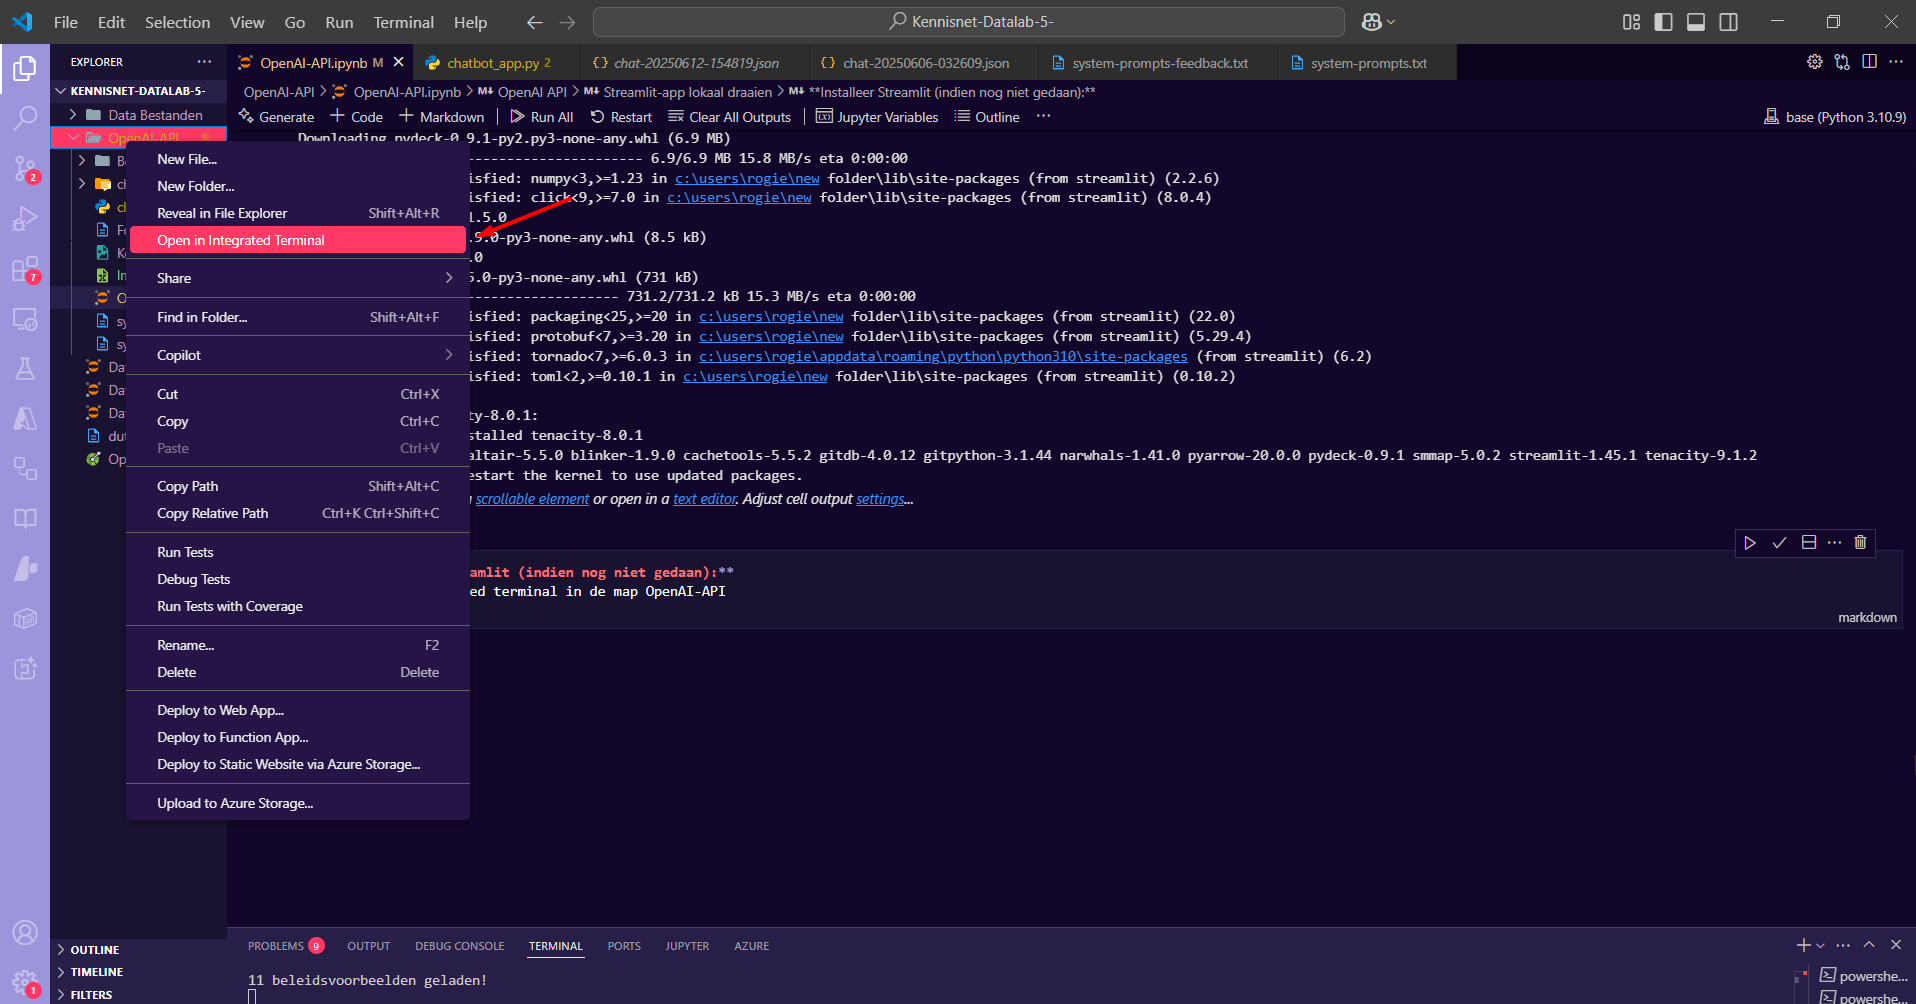


   OF voer de correcte map locatie in je terminal met cd:

   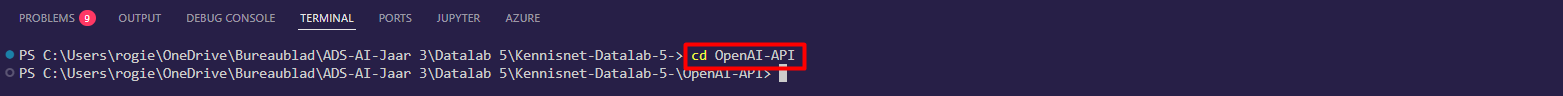



---

### 3. **.py bestand uitvoeren in de terminal:**

Dit doe je simpelweg met het volgende commando in de terminal:

``` streamlit run chatbot_app.py```

correcte uitvoering zal er zo uit zien: 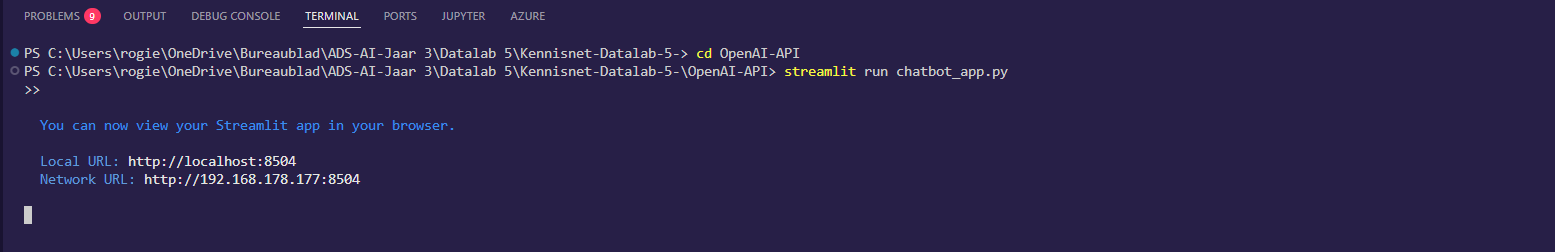

--- 

### 4. **Voer de API key in het geopende venster:**

Vanaf hier kun je volledig aan de slag met de chatbot

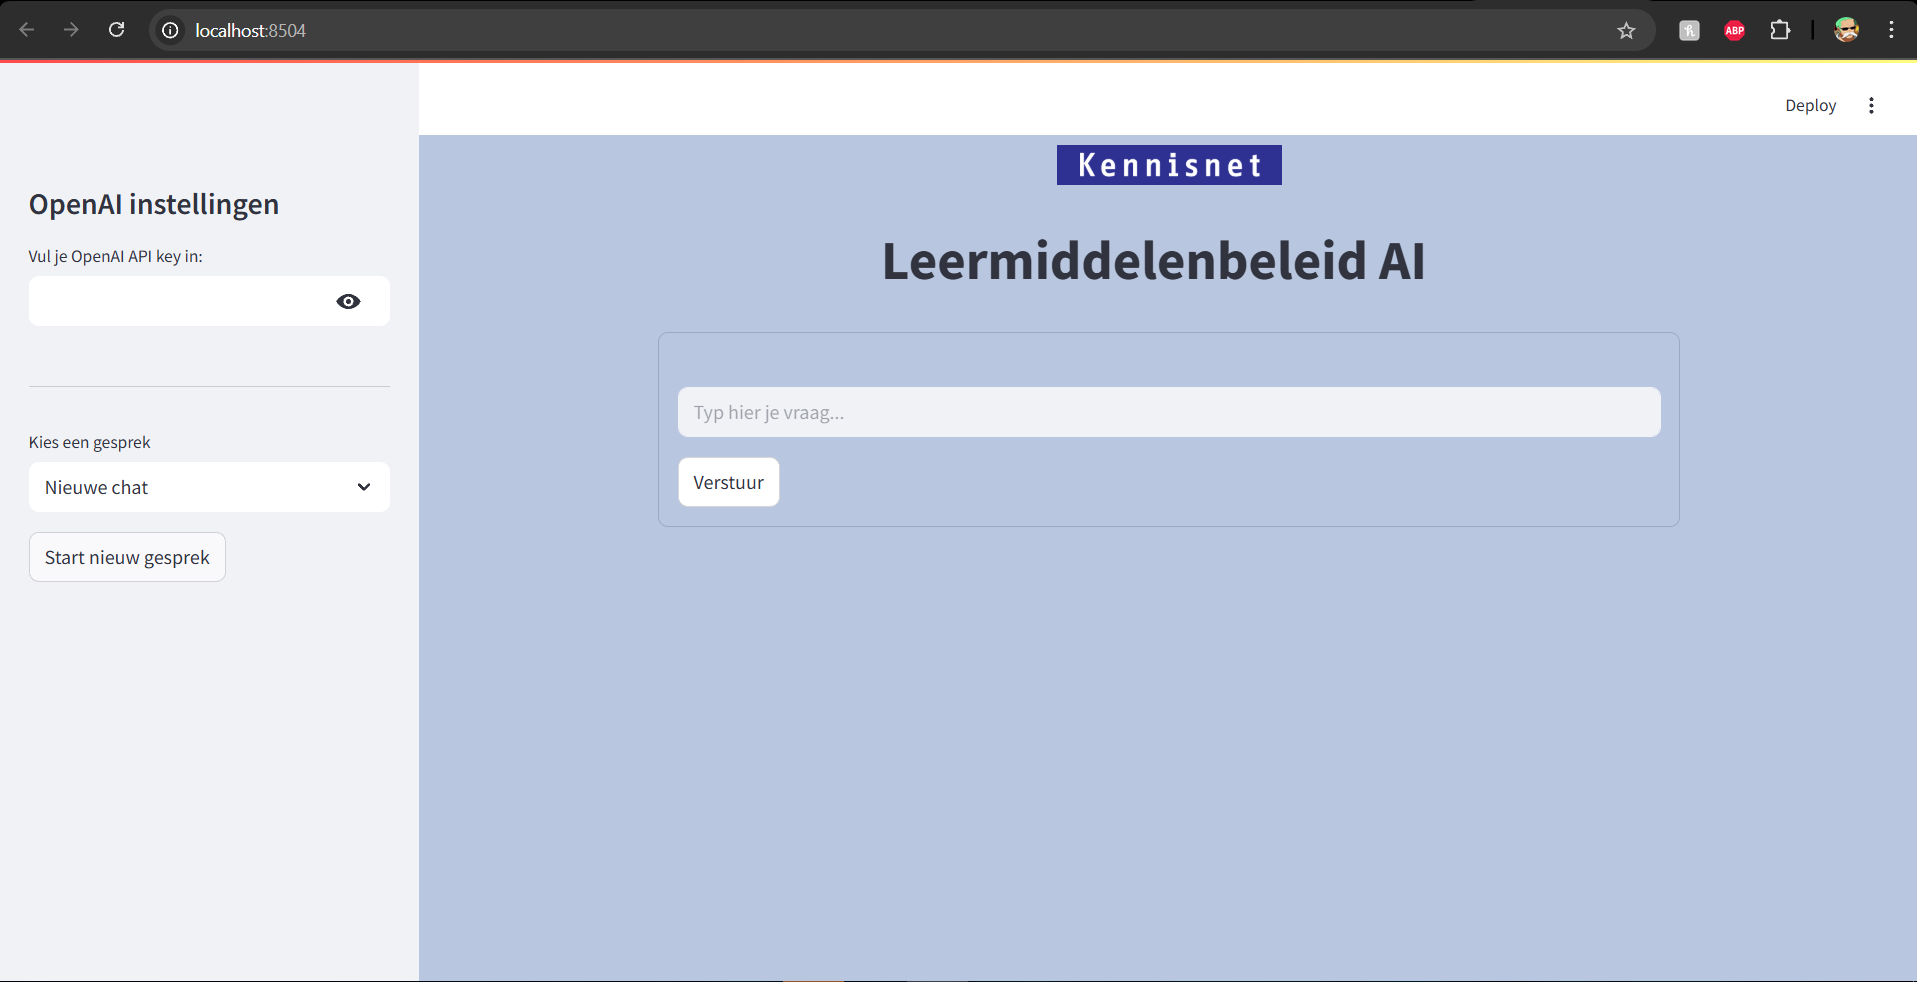